# A/B Testing

This notebook summarizes and provides example code in Python for several A/B Testing techniques.

In [1]:
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

In [2]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

## The Problem

Imagine two different samples of a measured value are distributed like `sample1` and `sample2` in Fig. 1.

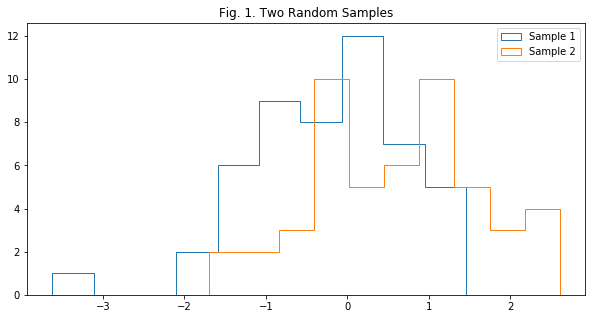

In [3]:
sample1 = np.random.normal(0, 1, size=50)
sample2 = np.random.normal(0.5, 1, size=50)

plt.figure(figsize=(10,5))
plt.hist(sample1, histtype='step', label='Sample 1')
plt.hist(sample2, histtype='step', label='Sample 2')
plt.legend()
plt.title('Fig. 1. Two Random Samples')
plt.show()

Is there a statistically significant difference in the means of both samples or are their differences due solely to chance? If the values are close enough to each other, the answer may not be obvious.

To check for a significant difference, we can test the likelihood of the null hypothesis. If there was no difference between the populations, what would be the likelihood of measuring our samples? If that likelihood or p-value is below some pre-determined significance level $\alpha$, which is typically set at 0.05, then it is concluded that the null hypothesis was false validating the alternative hypothesis that the two sample means are significantly different.

To be clear, a p-value below 0.05 does not mean that we have a 5% chance that the alternate hypothesis is true. For example, let's say we were checking for cancer and only 1 out of 100 test subjects actually have cancer. At a 95% significance level, 5 patients would have false positives and 1 patients would be correctly tested for cancer. So of the patients diagnosed with cancer, only 20% of them actually have cancer.

While this general technique is standard for hypothesis testing, the actual test used to measure the likelihood depends on the type of data.  The following table lists some common testing techniques for continuous and categorical data. This summary will only look through techniques comparing one or two random samples

Comparison            | Continuous               | Categorical
----------------------|--------------------------|------------
Sample and Constant   | One Sample t-test/z-test | Binomial Test
Two Unpaired Samples  | Two Sample t-test | Chi-Squared Test/Fisher's Exact Test
Three or More Samples | ANOVA                    | Chi-Squared Test

# 1. Continuous Tests

The continuous tests compare data that continuously varies. After describing each test, I will then implement them by testing whether a person's height needs to be significantly different from average in order to be a pop star. To check this, I'll specifically be testing for whether the heights of One Direction's former members are significantly different from England's mean using data from the [Health Survey for England](https://digital.nhs.uk/data-and-information/publications/statistical/health-survey-for-england/health-survey-for-england-2015-trend-tables) in 2015.

## 1.1 One Sample Test

One sample tests compare our sample's data versus a known population. There are several variations of this test depending on how well the population mean is known. 

The following tests all make the same assumptions about the populations.

**Assumptions**
- Independent and identically distributed random samples from each population
- Each population is normally distributed
- Unpaired populations

Paired populations are coupled to each other. For example, test subject populations before and after a medical treatment would be paired population. Whereas an unpaired population would include a random sample of participants who are divided into test and control groups. Variations on these tests are needed to handle paired populations.

The test to be used will be dependent on whether the population standard deviation is known (z-test) or whether it has to be estimated from the sample (t-test). When the population standard deviation is estimated from the sample, at large sample sizes (n > 30) results from t-test and z-tests will approach each other, but t-tests are more accurate for small sample sizes. As such, a t-test should always be used if the population standard deviation is unknown.

Test   | Criteria
-------|---------
T-Test | Population standard error is not known. Estimated from sample.
Z-Test | Known population standard error.

### Example: Pop Band Heights

In this example, the sample is the heights of the pop band members whereas the population is all English boys.

From the [Health Survey for England](https://digital.nhs.uk/data-and-information/publications/statistical/health-survey-for-england/health-survey-for-england-2015-trend-tables), the average height for 16-24 year old English men in 2015 is 176.9 cm. In contrast, the pop band's heights have been sampled as 173, 175, 175, 176, and 178 cm.

In Fig. 2, we see how the sample's heights differ from the population's means. Their heights are about 1.5 cm shorter than the population average. The one sample tests will decide whether this is that a clear bias for shorter members or the result of random sampling from the population.

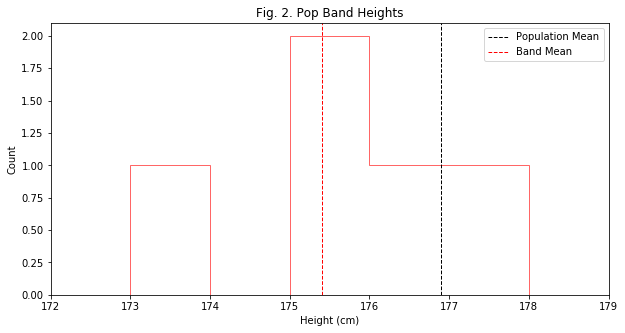

In [4]:
pop_mean = 176.9
sample = np.array([173, 178, 175, 175, 176])

plt.figure(figsize=(10,5))
plt.hist(sample, bins=5, histtype='step', color=(1,0.4,0.4))
plt.axvline(x=pop_mean, color=(0,0,0), linestyle='dashed', linewidth=1, label="Population Mean")
plt.axvline(x=sample.mean(), color='r', linestyle='dashed', linewidth=1, label="Band Mean")
plt.xlabel('Height (cm)')
plt.ylabel('Count')
plt.title('Fig. 2. Pop Band Heights')
plt.xlim((172, 179))
plt.legend()
plt.show()

## 1.1.1 One Sample Z-Test

Z-tests assume we already know the population's standard deviation.

The z-score is a measure of the variability between groups to the variability between groups.

### $z = \frac{\text{variability between groups}}{\text{variability within groups}}$

For sample mean $\bar{X}$, population mean $\mu$, and population standard error $\sigma_\bar{x}$,

### $z = \frac{\bar{X} - \mu}{\sigma_\bar{x}}$.

The z-score is a measure of how many population *standard errors* away the sample mean is from the population mean. 

This is standard errors away from the mean not standard deviations. The standard error describes the error on the calculated mean value and is dependent on sample size $n$ whereas the standard deviation $\sigma$ describes the spread in sampled values. They are related such that

### $\sigma_\bar{x} = \frac{\sigma}{\sqrt{n}}$.

With a larger sample size $n$, the standard error decreases and the sample mean is expected to be closer to the population mean.

Altogether, the z-score is then

### $z = \frac{\bar{X} - \mu}{\frac{\sigma}{\sqrt{n}}}$.

The area in the shaded region of Fig. 3 yields the probability or p-value that the sample mean $\bar{X}$ would be as far away from $\mu$ as measured or more. A *two-sided test* checks the probability the $\bar{X}$ would be greater or smaller than $\mu$ whereas a *one-sided test* only checks one of those sides.

For a z-test, that p-value is compared with a pre-determined significance level $\alpha$ which is typically set at 0.05. If the p-value is smaller than $\alpha$ then the null hypothesis is false and the two means are considered significantly different. However, it does not tell us which alternate hypothesis is correct. For a larger p-value, the differences between the two means could be the result of random variations in the sampling.

### Example: One-Sample Z-Test

From the [Health Survey for England](https://digital.nhs.uk/data-and-information/publications/statistical/health-survey-for-england/health-survey-for-england-2015-trend-tables), the average height for 16-24 year old English men in 2015 is 176.9 cm with a standard deviation of 8.14 cm (Fig. 3). 

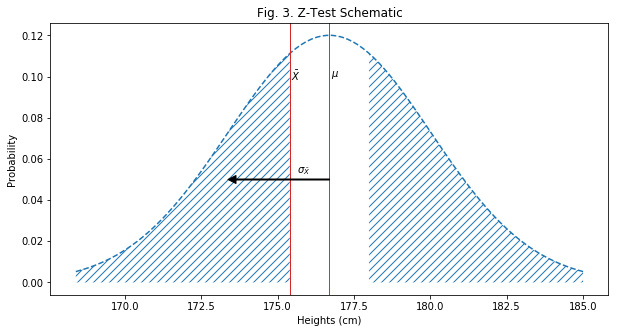

In [5]:
pop_mean = 176.7 # England's average height for boys (cm)
pop_std = 8.14 # England's height standard deviation for boys (cm)
pop_stderr = pop_std/np.sqrt(6) # Standard error using the sample size
sample = np.array([173, 178, 175, 175, 176]) # One Direction's heights (cm)
sample_mean = sample.mean()
diff = np.abs(pop_mean - sample_mean)

plt.figure(figsize=(10,5))
cmap = plt.get_cmap("tab10")
x = np.linspace(pop_mean - 2.5 * pop_stderr, pop_mean + 2.5 * pop_stderr, 100)
y = stats.norm.pdf(x, pop_mean, pop_stderr)
plt.plot(x,y, '--')

x = np.linspace(pop_mean - 2.5 * pop_stderr, pop_mean - diff, 100)
y = stats.norm.pdf(x, pop_mean, pop_stderr)
plt.fill_between(x, y, facecolor='none', edgecolor=cmap(0), hatch='///', linewidth=0)

x = np.linspace(pop_mean + diff, pop_mean + 2.5 * pop_stderr, 100)
y = stats.norm.pdf(x, pop_mean, pop_stderr)
plt.fill_between(x, y, facecolor='none', edgecolor=cmap(0), hatch='///', linewidth=0)

plt.axvline(x=pop_mean, color=cmap(0), linewidth=1, label="Population Mean")
plt.annotate(r'$\mu$', (pop_mean+0.05, 0.1))
plt.axvline(x=sample_mean, color=cmap(3), linewidth=1, label="Sample Mean")
plt.annotate(r'$\bar{X}$', (sample_mean+0.04, 0.098))
plt.annotate('', xy=(pop_mean-pop_stderr, 0.05), xytext=(pop_mean, 0.05),
            arrowprops=dict(facecolor='black', width=1, headlength=8, headwidth=8))
plt.annotate(r'$\sigma_\bar{X}$', (pop_mean-0.32*pop_stderr, 0.053))
plt.title('Fig. 3. Z-Test Schematic')
plt.xlabel('Heights (cm)')
plt.ylabel('Probability')
plt.show()

Because we know the population's standard deviation, we can do a z-test.

In [6]:
sample = np.array([173, 178, 175, 175, 176]) # One Direction's heights (cm)
pop_mean = 176.9 # England's average height for boys (cm)
pop_std = 8.14

def ztest(sample, pop_mean, pop_std):
    z = (sample.mean() - pop_mean)/(pop_std/np.sqrt(sample.size))
    pval = 2*(stats.norm.sf(np.abs(z))) #Two-sided Test
    return(z, pval)

z, pval = ztest(sample, pop_mean, pop_std)
print('z-score: {:.3}, p-value: {:.2}'.format(z, pval))

z-score: -0.412, p-value: 0.68


The p-value is much greater than our 0.05 significance level so the pop band does not have heights significantly different from England's average.

## 1.1.2 One Sample T-Test

T-tests are used when the population standard error is not known. Instead, it uses the sample's standard deviation.

For sample mean $\bar{X}$, population mean $\mu$, and sample standard error $\sigma_\bar{x}$,

### $t = \frac{\bar{X} - \mu}{\sigma_\bar{x}}$.

For sample standard deviation $s$ and sample size $n$, the sample standard error 

### $\sigma_\bar{x} = \frac{s}{\sqrt{n}}$.

Because this is a sample standard deviation and not a population standard deviation, $s$ should have $n-1$ degrees of freedom as per Bessel's correction.

Instead of being described with a normal distribution, the population is described by a t-distribution with $n-1$ degrees of freedom (Fig. 4). A t-distribution is similar to a normal distribution but slightly varies depending on the degrees of freedom. This distinction is more important at small sample sizes where the t-distribution gives more emphasis to points at the extremes. Whereas at large sample sizes ($n$ > 30), the t-distribution approaches the normal distribution.

### Example: One Sample T-Test

According to the [survey](https://digital.nhs.uk/data-and-information/publications/statistical/health-survey-for-england/health-survey-for-england-2015-trend-tables), the average height for 16-24 year old English men in 2015 is 176.9 cm. Without the standard deviation for the population, a t-test is used to determine significance (Fig. 4).

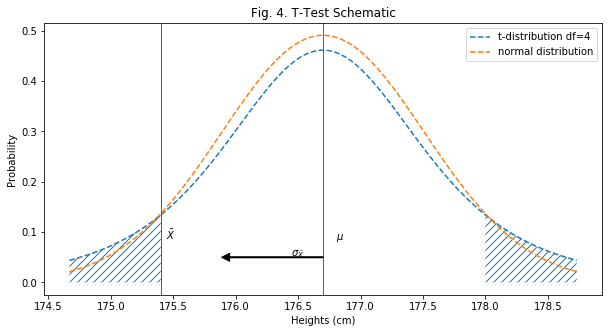

In [7]:
sample = np.array([173, 178, 175, 175, 176]) # One Direction's heights (cm)
n = len(sample)
sample_mean = sample.mean()
pop_mean = 176.7 # England's average height for boys (cm)
pop_std = sample.std(ddof=1) # Standard deviation calculated from sample
pop_stderr = pop_std/np.sqrt(n) # Standard error using the sample size

diff = np.abs(pop_mean - sample_mean)

plt.figure(figsize=(10,5))
cmap = plt.get_cmap("tab10")
x = np.linspace(pop_mean - 2.5 * pop_stderr, pop_mean + 2.5 * pop_stderr, 100)
y = stats.t.pdf(x, n-1, pop_mean, pop_stderr)
plt.plot(x,y, '--', color=cmap(0), label='t-distribution df={}'.format(n-1))

y = stats.norm.pdf(x, pop_mean, pop_stderr)
plt.plot(x,y, '--', color=cmap(1), label='normal distribution')

x = np.linspace(pop_mean - 2.5 * pop_stderr, pop_mean - diff, 100)
y = stats.t.pdf(x, n-1, pop_mean, pop_stderr)
plt.fill_between(x, y, facecolor='none', edgecolor=cmap(0), hatch='///', linewidth=0)

x = np.linspace(pop_mean + diff, pop_mean + 2.5 * pop_stderr, 100)
y = stats.t.pdf(x, n-1, pop_mean, pop_stderr)
plt.fill_between(x, y, facecolor='none', edgecolor=cmap(0), hatch='///', linewidth=0)

plt.axvline(x=pop_mean, color=cmap(0), linewidth=1)
plt.annotate(r'$\mu$', (pop_mean+0.1, 0.085))
plt.axvline(x=sample_mean, color=cmap(3), linewidth=1)
plt.annotate(r'$\bar{X}$', (sample_mean+0.04, 0.084))
plt.annotate('', xy=(pop_mean-pop_stderr, 0.05), xytext=(pop_mean, 0.05),
            arrowprops=dict(facecolor='black', width=1, headlength=8, headwidth=8))
plt.annotate(r'$\sigma_\bar{X}$', (pop_mean-0.32*pop_stderr, 0.053))
plt.title('Fig. 4. T-Test Schematic')
plt.xlabel('Heights (cm)')
plt.ylabel('Probability')
plt.legend()
plt.show()

Now we can perform the t-test.

In [8]:
sample = np.array([173, 178, 175, 175, 176]) # One Direction's heights (cm)
pop_mean = 176.9 # England's average height for boys (cm)

def ttest(sample, pop_mean):
    t = (sample.mean() - pop_mean)/(sample.std(ddof=1)/np.sqrt(sample.size))
    pval = 2*stats.t.sf(np.abs(t), df=(sample.size-1)) #Two-sided test
    return(t, pval)

t, pval = ttest(sample, pop_mean)
print('t-score: {:.3}, p-value: {:.2}'.format(t, pval))

t-score: -1.85, p-value: 0.14


This can be calculated more quickly, but using the build-in function.

In [9]:
onesample_ttest_results = stats.ttest_1samp(sample, pop_mean)
print('t-score: {:.3}, p-value: {:.2}'.format(onesample_ttest_results.statistic, onesample_ttest_results.pvalue))

t-score: -1.85, p-value: 0.14


The T-Test also shows that the average of their heights are not significantly different from the population's mean. However, it is much more significant in this test due to the assumption that population's standard deviation can be approximated by the sample's. This leads to a much smaller standard error (Fig. 4).

## 1.2 Two Sample Test

A two sample test compares the means of two samples. Unlike in the one sample case, neither population is treated like a constant. Instead, the sample values $X$ themselves or $\mu$, $\sigma$ and $n$ are needed for each sample.

There are several variations which assume that the variances or samples sizes are the same. Welch's t-test gives better results even when those statistics are not the same and thus is the default method you should use.

## Example

We are going to no longer treat the mean height as some definitive constant but rather as the result of another sampling. The [Health Survey for England](https://digital.nhs.uk/data-and-information/publications/statistical/health-survey-for-england/health-survey-for-england-2015-trend-tables) specifically says that the average height for 16-24 year old English men in 2015 is 176.9 cm with a standard error of 0.5 cm as determined from a sample size of 265 participants. 

The standard deviation of the population can be calculated from the standard error.

In [10]:
std_pop = np.sqrt(265)*0.5
print('Population Standard Deviation: {:.3} cm'.format(std_pop))

Population Standard Deviation: 8.14 cm


While the sampled heights from the survey were not given, we can use random variables distributed accordign to those values to see how the population's heights diverge from the band's heights as in Fig. 5.

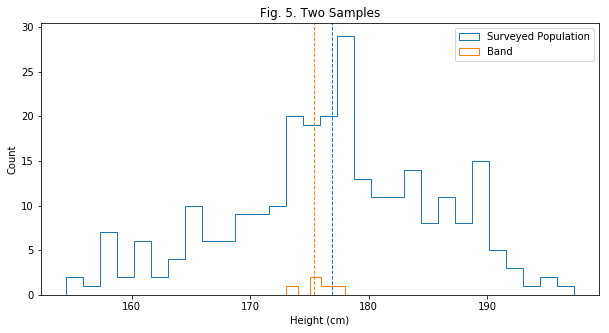

In [11]:
pop = np.random.normal(176.9, 8.14, size=265)
sample = np.array([173, 178, 175, 175, 176])

plt.figure(figsize=(10,5))
cmap = plt.get_cmap("tab10")

plt.hist(pop, bins=30, color=cmap(0), histtype='step', label="Surveyed Population")
plt.hist(sample, bins=5, color=cmap(1), histtype='step', label="Band")
plt.axvline(x=pop.mean(), color=cmap(0), linestyle='dashed', linewidth=1)
plt.axvline(x=sample.mean(), color=cmap(1), linestyle='dashed', linewidth=1)
plt.xlabel('Height (cm)')
plt.ylabel('Count')
plt.title('Fig. 5. Two Samples')
plt.legend()
plt.show()

Alternatively, we can check the probability density functions for the means of the samples.

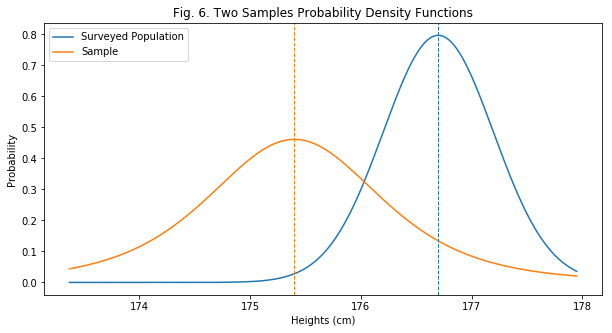

In [12]:
sample = np.array([173, 178, 175, 175, 176]) # One Direction's heights (cm)
sample_mean = sample.mean()
sample_n = n = len(sample)
sample_std = sample.std(ddof=1)
sample_stderr = sample_std/np.sqrt(sample_n)

pop_mean = 176.7 # England's average height for boys (cm)
pop_std = 8.14
pop_n = 265
pop_stderr = pop_std/np.sqrt(pop_n) # Standard error using the sample size

diff = np.abs(pop_mean - sample_mean)

plt.figure(figsize=(10,5))
cmap = plt.get_cmap("tab10")

x = np.linspace(sample_mean - 2.5 * sample_stderr, pop_mean + 2.5 * pop_stderr, 500)
y = stats.t.pdf(x, pop_n-1, pop_mean, pop_stderr)
plt.plot(x,y, '-', color=cmap(0), label='Surveyed Population')

x = np.linspace(sample_mean - 2.5 * sample_stderr, pop_mean + 2.5 * pop_stderr, 500)
y = stats.t.pdf(x, sample_n-1, sample_mean, sample_stderr)
plt.plot(x,y, '-', color=cmap(1), label='Sample')

plt.axvline(x=pop_mean, ls='--', color=cmap(0), linewidth=1)
plt.axvline(x=sample_mean, ls='--', color=cmap(1), linewidth=1)

plt.title('Fig. 6. Two Samples Probability Density Functions')
plt.xlabel('Heights (cm)')
plt.ylabel('Probability')
plt.legend()
plt.show()

## 1.2.1 Welch's T-Test

Welch's t-test does not assume the size or variance of the two samples are the same.

Once again the t-score is the ratio of the difference between the means in the groups to the variability within the groups. For sample mean $\bar{x}$, sample standard deviation $s$, and sample size $n$,

### $t = \frac{| \bar{x}_1 - \bar{x}_2 |}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$.

The p-value is once again determined with the t-score from t-distribution with degrees of freedom $\nu$ where

### $\nu \approx \frac{ \left( \frac{s_1^2}{N_1} + \frac{s_2^2}{N_2} \right)^2 }{ \frac{s_1^4 }{N_1^2 v_1} + \frac{s_2^4}{N_2^2 v_2} }$.

### Example: Welch's T-Test

From Fig. 5, we see that the band's heights and the survey's reported heights are two separate samples. While the variance for the survey population is significantly higher than for the band, in Fig 6 we see that the increase in sample size actually means that the standard error for the surveyed average height is smaller. 

For the actual two-sample test (Fig. 7), the differences between the means will be compared to see if they are significantly different.

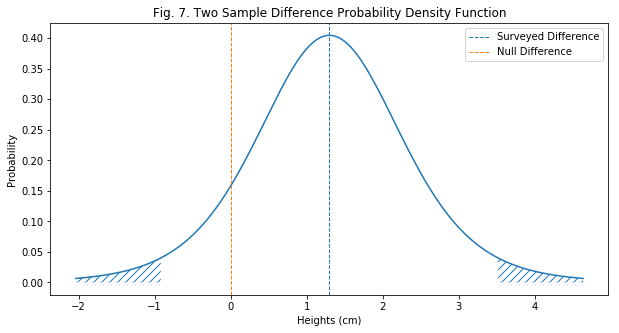

In [13]:
sample = np.array([173, 178, 175, 175, 176]) # One Direction's heights (cm)
sample_mean = sample.mean()
sample_n = n = len(sample)
sample_std = sample.std(ddof=1)
sample_stderr = sample_std/np.sqrt(sample_n)

pop_mean = 176.7 # England's average height for boys (cm)
pop_std = 8.14
pop_n = 265
pop_stderr = pop_std/np.sqrt(pop_n) # Standard error using the sample size

diff_mean = np.abs(pop_mean - sample_mean)
diff_stderr = np.sqrt(pop_std**2/pop_n + sample_std**2/sample_n)

def dof(sd1, sd2, n1, n2):
    return((sd1**2/n1 + sd2**2/n2)**2/(sd1**4/n1**2/(n1-1)+sd2**4/n2**2/(n2-1)))
df = dof(sample_std, pop_std, sample_n, pop_n)

plt.figure(figsize=(10,5))
cmap = plt.get_cmap("tab10")

x = np.linspace(diff_mean - 3.5 * diff_stderr, diff_mean + 3.5 * diff_stderr, 500)
y = stats.t.pdf(x, df, diff_mean, diff_stderr)
plt.plot(x,y, '-', color=cmap(0))

x = np.linspace(diff_mean - 3.5 * diff_stderr, stats.t.ppf(0.025, df, diff_mean, diff_stderr), 500)
y = stats.t.pdf(x, df, diff_mean, diff_stderr)
plt.fill_between(x, y, facecolor='none', edgecolor=cmap(0), hatch='///', linewidth=0)

x = np.linspace(stats.t.ppf(0.975, df, diff_mean, diff_stderr), diff_mean + 3.5 * diff_stderr, 500)
y = stats.t.pdf(x, df, diff_mean, diff_stderr)
plt.fill_between(x, y, facecolor='none', edgecolor=cmap(0), hatch='///', linewidth=0)

plt.axvline(x=diff_mean, ls='--', color=cmap(0), linewidth=1, label='Surveyed Difference')
plt.axvline(x=0, ls='--', color=cmap(1), linewidth=1, label='Null Difference')

plt.title('Fig. 7. Two Sample Difference Probability Density Function')
plt.xlabel('Heights (cm)')
plt.ylabel('Probability')
plt.legend()
plt.show()

First, we'll compute the t-test by hand.

In [14]:
sample = np.array([173, 178, 175, 175, 176]) # One Direction's heights (cm)
sample_mean = sample.mean()
sample_std = sample.std(ddof=1)
n_sample = len(sample)
pop_mean = 176.9 # England's average height for boys (cm)
pop_std = 8.14
n_pop = 265

def dof(sd1, sd2, n1, n2):
    return((sd1**2/n1 + sd2**2/n2)**2/(sd1**4/n1**2/(n1-1)+sd2**4/n2**2/(n2-1)))

def twoSampT(X1, X2, sd1, sd2, n1, n2):
    df = dof(sd1, sd2, n1, n2)
    pooledSE = np.sqrt(sd1**2/n1 + sd2**2/n2)
    t = np.abs(X1 - X2)/pooledSE
    pval = 2*stats.t.sf(np.abs(t), df)
    return(t, pval)

t, pval = twoSampT(sample_mean, pop_mean, sample_std, pop_std, n_sample, n_pop)
print('t-score: {:.3}, p-value: {:.2}'.format(t, pval))

t-score: 1.57, p-value: 0.16


And now we'll use build-ins to calculate the p-value.

In [15]:
twosample_ttest_results = stats.ttest_ind_from_stats(pop_mean, pop_std, n_pop, 
                                                     sample_mean, sample_std, n_sample, equal_var=False)
print('t-score: {:.3}, p-value: {:.2}'.format(twosample_ttest_results.statistic, twosample_ttest_results.pvalue))

t-score: 1.57, p-value: 0.16


Once again, there is no significant differences between the means, but from Fig. 5 we might infer that there is a signficant difference in the variations of each population. 

## 1.3 Fisher's F-Test

Fisher's F-Test is used when comparing the variance of two populations. This tests the null hypothesis that two variances are the same.

### $f = \frac{s_1^2}{s_2^2}$

The f-score and the degrees of freedom for each sample are used with the f-distribution to determine the p-value. A low p-value indicates that the variances are significantly different from each other.

### Example: Fisher's F-Test

We will use the Fisher's F-Test to determine whether the variance in their heights is significantly different from the populations.

In this case the degrees of freedom for each sample is `n - 1` because the sample is being used as a subset of a greater population. 

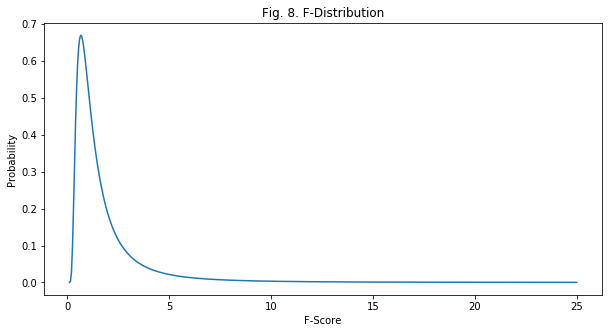

In [16]:
sample = np.array([173, 178, 175, 175, 176]) # One Direction's heights (cm)
pop_var = (265-1)*0.5**2
pop_df = 265 - 1
sample_var = sample.var(ddof=1)
sample_df = len(sample) - 1

f= pop_var / sample_var


plt.figure(figsize=(10, 5))
x = np.linspace(f, 25, 100)
y = stats.f.pdf(x, pop_df, sample_df)
plt.fill_between(x, y, facecolor='none', edgecolor=cmap(0), hatch='///', linewidth=0)

x = np.linspace(0.1, 25, 500)
y = stats.f.pdf(x, pop_df, sample_df)
plt.plot(x, y)
plt.xlabel('F-Score')
plt.ylabel('Probability')
plt.title('Fig. 8. F-Distribution')

plt.show()

The f-distribution is shown in Fig. 8. For our sample, the f-score is 20 which is in the far tail of the f-distribution. As such, the associated p-value is expected to be very small.

In [17]:
sample = np.array([173, 178, 175, 175, 176]) # One Direction's heights (cm)
pop_var = (265-1)*0.5**2
pop_df = 265 - 1
sample_var = sample.var(ddof=1)
sample_df = len(sample) - 1

f= pop_var / sample_var
single_tailed_pvalue = stats.f.sf(f, pop_df, sample_df)
print('f-score: {:0.3}, p-value: {:0.3}'.format(f, single_tailed_pvalue))

f-score: 20.0, p-value: 0.00471


The f-test shows that the One Direction boys have much more similar heights to each other than would be expected from a sampling of UK boys.

Thus, to form a pop band like One Direction, the heights of the members does not need to be significantly different from the population as a whole but their heights have to be closer to one another than normal.

# 2. Categorical/Proportion Test

### Example 2: Website

In 2013, the number of unique visitors to Wikipedia hit [517 million per month](https://thenextweb.com/insider/2013/04/19/sites-owned-by-the-wikimedia-foundation-now-receive-over-500m-unique-visitors-each-month/). We'll assume that most visitors are repeat vistors and that the yearly number of unique visitors was about the same. For that fiscal year Wikipedia raised money from [2.5 million donors](https://meta.wikimedia.org/wiki/Fundraising/2013-14_Report). This means that under 0.5% of Wikipedia visitors actually donated money to the site.

Wikipedia does extensive A/B testing on its fundraising banners. For example, by targeting viewer by their nation, they found a [7% increase](https://foundation.wikimedia.org/wiki/2016-2017_Fundraising_Report) in donors. Considering that a 7% increase in donor rate is a difference between 0.48% and 0.52% of unique visitors donating, I'd like to confirm whether Wikipedia can even determine whether such a minor change is statistically significant.

## 2.1 Sample Size

We first need to determine how large our sample sizes should be in order to get the sensitivity that we want.

Fig. 9 provides an interactive diagram where the probability distribution for the average from the null hypothesis $H_0$ is compared with the probability distribution from a specified alternative hypothesis $H_1$. As the sample size $n$ increases, the standard error for each hypothesis becomes smaller and it would be easier to distinguish between them. Similarly, if $H_1$ expected a larger percent change over $H_0$, then it is easier to distinguish the two hypotheses. 

There are two types of error expect. Type I errors $\alpha$ is shown as blue cross-hatches. These are areas where the null hypothesis $H_0$ would be rejected even when true because the measured average would be too far different from the expected average. The tolerance for type I errors is set with the significance level.

Type II errors $\beta$ are when the specified alternative hypothesis $H_1$ would be rejected in favor of $H_0$ even if $H_1$ was correct. The power $1 - \beta$ is the likelihood that the test would be able to a statistically significant change if $H_1$ was true. 

The typical convention is to set $\alpha = 0.05$ and $\beta = 0.2$ but they may vary depending on the needs of the experiment.

In [18]:
plt.rcParams.update({'font.size': 14})

@interact(n=widgets.IntSlider(value=200000, min=5000, max=20000000, description='n: '),
         percent_change=widgets.FloatSlider(value=1.0, min=1.0, max=10.0, step=0.1, description='% Change: '))
def plot(n, percent_change): #n for each group
    h0_p = 0.0048 # Control value
    h1_p = h0_p * (1 + percent_change/100)
    h0_std = np.sqrt(h0_p * (1 - h0_p))
    h1_std = np.sqrt(h1_p * (1 - h1_p))
    h0_stderr = h0_std / np.sqrt(n)
    h1_stderr = h1_std / np.sqrt(n)
    x_min = 0.0045
    x_max = 0.0058
    power = stats.norm.sf(stats.norm.ppf(0.975, h0_p, h0_stderr), h1_p, h1_stderr)

    plt.figure(figsize=(10,5))
    cmap = plt.get_cmap("tab10")

    x = np.linspace(x_min, x_max, 500)
    y = stats.norm.pdf(x, h0_p, h0_stderr)
    plt.plot(x, y, color=cmap(0), label='Null')

    x = np.linspace(x_min, x_max, 500)
    y = stats.norm.pdf(x, h1_p, h1_stderr)
    plt.plot(x, y, color=cmap(1), label='{}% Change'.format(percent_change))

    x = np.linspace(stats.norm.ppf(0.975, h0_p, h0_stderr), x_max, 500)
    y = stats.norm.pdf(x, h0_p, h0_stderr)
    plt.fill_between(x, y, facecolor='none', edgecolor=cmap(0), hatch='///', linewidth=0, label=r'$\alpha/2$')


    x = np.linspace(x_min, stats.norm.ppf(0.975, h0_p, h0_stderr), 500)
    y = stats.norm.pdf(x, h1_p, h1_stderr)
    plt.fill_between(x, y, facecolor='none', edgecolor=cmap(1), hatch='///', linewidth=0, label=r'$\beta$')

    plt.legend(bbox_to_anchor=(1.3, 0.75), fancybox=True, shadow=True)
    plt.xlim((x_min, x_max))
    plt.title('Fig. 9. Calculating Sample Size (Power = {:.2f})'.format(power))
    plt.show()

interactive(children=(IntSlider(value=200000, description='n: ', max=20000000, min=5000), FloatSlider(value=1.…

The actual sample size we want will be

### $n >= \frac{\left( \sigma_1  t_{1-\beta} + \sigma_0 t_{1-\alpha/2} \right)^2}{\delta^2}$,

where $\delta$ is the minimum change we are looking to detect, $\sigma_0$ and $\sigma_1$ are the standard deviations for $H_0$ and $H_1$ respectively, and the $t$ scores from the associated $n-1$ degree of freedom t-distribution. However, for large $n$, the t-scores can be approximated by z-scores and both standard deviations can likely be approximated by single standard deviation $\sigma$.

In which case for $\alpha = 0.05$ and $\beta = 0.05$, the rule of thumb is that you need

### $n >= 16 \frac{\sigma^2}{\delta^2}$

Let's calculate these values.

In [19]:
a = 0.05
b = 0.2
h0_p = 0.0048 # Control value
c = 0.01 # Estimated percent change between h0 to h1
h1_p = h0_p * (1 + c)
h0_std = np.sqrt(h0_p * (1 - h0_p))
h1_std = np.sqrt(h1_p * (1 - h1_p))
d = h1_p - h0_p 

print('\u03B1: {}, \u03B2: {}, n: {:,.0f}'.format(a, b, (h1_std * stats.norm.ppf(1-b) + h0_std * stats.norm.ppf(1-a/2))**2/d**2))

α: 0.05, β: 0.2, n: 16,321,908


To be able to detect a 1% change, we'll need roughly 16 million samples. For a 2% change, we'll need 4 million samples. Wikipedia has over 500 million unique visitors per month. Due to their sheer number of visitors, they are able to apply A/B tests to detect such a small change.

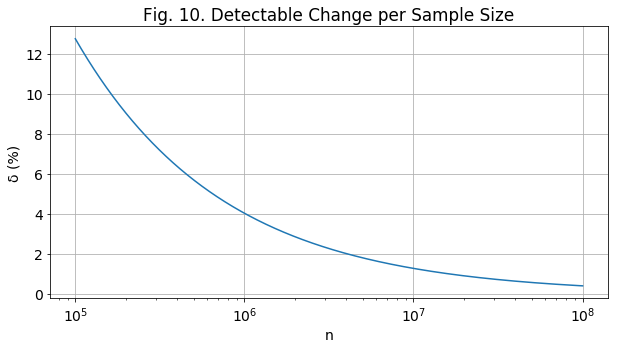

In [20]:
a = 0.05
b = 0.2
h0_p = 0.0048 # Control value
c = 0.01 # Estimated percent change between h0 to h1
h1_p = h0_p * (1 + c)
h0_std = np.sqrt(h0_p * (1 - h0_p))
h1_std = np.sqrt(h1_p * (1 - h1_p))

s = h0_std * (stats.norm.ppf(1-b) + stats.norm.ppf(1-a/2))

plt.figure(figsize=(10,5))
n = np.logspace(5, 8, 100000)
d = np.array([s/np.sqrt(i)*100/h0_p for i in n])
plt.plot(n,d)
plt.grid()
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('n')
plt.ylabel('\u03B4 (%)')
plt.title('Fig. 10. Detectable Change per Sample Size')
plt.show()

We can also do the size estimate more accurately by using t-scores, but the difference is negligible for these sample sizes. Plus, because the t-scores are used to solve for $n$ while being dependent on $n$ for their degrees of freedom, the sample size has to first be estimated before calculated. This process can then be repeated using the calculated value as the estimate value for $n$ until there is no difference. Typically, only one round of iteration is necessary.

In [21]:
a = 0.05
b = 0.2
h0_p = 0.0048 # Control value
c = 0.01 # Estimated percent change between h0 to h1
h1_p = h0_p * (1 + c)
h0_std = np.sqrt(h0_p * (1 - h0_p))
h1_std = np.sqrt(h1_p * (1 - h1_p))
h0_stderr = h0_std / np.sqrt(n)
h1_stderr = h1_std / np.sqrt(n)
d = h1_p - h0_p 
n = 16321910
s = (h1_std * stats.t.ppf(1-b, n-1) + h0_std * stats.t.ppf(1-a/2, n-1))

print('\u03B1: {}, \u03B2: {}, n: {:,.0f}'.format(a, b, s**2/d**2))

α: 0.05, β: 0.2, n: 16,321,910


## 2.2 One-Sample Test

If we designed the test to be able to detect a 2% change, we would need 4 million samples.

First, we want to check the significance of whether our sample is different from the control. This is similar to the one-sample significance tests we did for the continuous data but with categorical/binary data. This test can be approximated at large $n$ using a z-test or a chi-squared test or done more exactly with the binomial test.

### 2.2.1 Binomial Test

The probability of having a certain number of donors follows a binomial distribution which at large $n$ is similar to discrete normal distribution.

### $Pr(X=k) = \binom{n}{k} p^k (1-p)^{n-k}$

The sampled number of donors can then be compared to the binomial distribution to determine the probability of geting the sampled result.

Fig. 11. compares the sampled percent of donors with the expected control. While the binomial distribution is specifically a distribution specifying the number of sampled values, in this figure I've translated it to show proportions which are easier to understand.

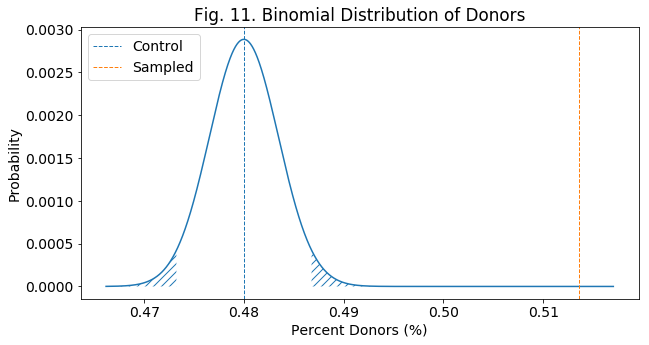

In [22]:
n = 4000000
p = 0.0048
p_new = p * 1.07
mean = n * p
mean_new = n * p_new
std = np.sqrt(n * p * (1 - p))

cmap = plt.get_cmap("tab10")
plt.figure(figsize=(10,5))

x = np.arange(int(mean - 4*std), int(max(n*p_new + std, mean + 3*std)))
y = stats.binom.pmf(x, n, p)
plt.plot(x*100/n,y, color=cmap(0))

x = np.arange(int(mean - 4*std), int(stats.binom.ppf(0.025, n, p)))
y = stats.binom.pmf(x, n, p)
plt.fill_between(x*100/n, y, facecolor='none', edgecolor=cmap(0), hatch='///', linewidth=0)

x = np.arange(int(stats.binom.ppf(0.975, n, p)), int(max(n*p_new + std, mean + 3*std)))
y = stats.binom.pmf(x, n, p)
plt.fill_between(x*100/n, y, facecolor='none', edgecolor=cmap(0), hatch='///', linewidth=0)

plt.axvline(x=mean*100/n, ls='--', color=cmap(0), linewidth=1, label='Control')
plt.axvline(x=mean_new*100/n, ls='--', color=cmap(1), linewidth=1, label='Sampled')

plt.xlabel('Percent Donors (%)')
plt.ylabel('Probability')
plt.title('Fig. 11. Binomial Distribution of Donors')
plt.legend()
plt.show()

Now, we can check for the associated p-value. It's ridiculously low because we set the experiment size to deal with a 2% change but found a 7% change.

In [23]:
print('p-value: {:.2}'.format(stats.binom_test(mean_new, n, p, 'two-sided')))

p-value: 6.9e-22


Generally, once initiated tests should be finished completely before deciding significance. In situations like this one where millions of data points are needed to be sampled before the test is concluded and the p-value it super low, it may be tempting to end early. However, prematurely peeking and ending a test once a desired p-value is reached compounds the errors associated with the test and can make interpreting results difficult. However, there are techniques like *sequential testing* where the test can be ended early if the results are entirely one-sided.

## 2.2.1 Single-Factor Chi-Squared

We will also use the chi-squared approximation to compare our observed samples to the expected values based on the control. The chi-squared test is valid becasue none of our categories have 5 or fewer counts. 

The data we are going to be working with is as follows.

Donated? |Observed     |Expected
---------|-------------|-----------
True     |h1_p\*n      |h0_p\*n
False    |(1-h1_p)\*n  |(1-h0_p)\*n

The chi-squared test computes $\chi^2$ for each category where

### $ \chi^2 = \sum_{i=1}^k \frac{(O_i -E_i)^2}{E_i}$.

The calculated value is then compared with the $\chi^2$-distribution (Fig. 12). The $\chi^2$-distribution shows the likelihood of getting any value of chi-squared based on the degrees of freedom $k-1$. The degrees of freedom isn't based on the number of samples but rather the number of categories $k$.

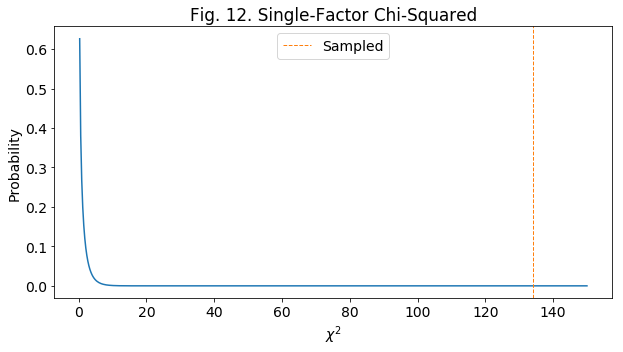

In [24]:
n = 4000000
h0_p = 0.0048
h1_p = 0.0052

chi_squared = n*(h1_p-h0_p)**2/h0_p + n*((1-h1_p) - (1-h0_p))**2/(1-h0_p)

cmap = plt.get_cmap("tab10")
plt.figure(figsize=(10,5))

x = np.linspace(0, 150, 500)
y = stats.chi2.pdf(x, df=1)
plt.plot(x,y, color=cmap(0))
plt.xlabel(r'$\chi^2$')
plt.ylabel('Probability')
plt.axvline(x=chi_squared, ls='--', color=cmap(1), linewidth=1, label='Sampled')
plt.title('Fig. 12. Single-Factor Chi-Squared')
plt.legend()
plt.show()

In Fig. 12, we see that our $\chi^2$ value is far from likely. Let's calculate the p-value by hand.

In [25]:
n = 4000000
h0_p = 0.0048
h1_p = 0.0052

chi_squared = n*(h1_p-h0_p)**2/h0_p + n*((1-h1_p) - (1-h0_p))**2/(1-h0_p)
single_tailed_pvalue = stats.chi2.sf(chi_squared, df=1)
print('chi-squared:', ': {:.3}, p-value: {:.2}'.format(chi_squared, single_tailed_pvalue))

chi-squared: : 1.34e+02, p-value: 5.5e-31


As expected, the test is significantly different from the control. Now, let's do the calculation using built-ins.

In [26]:
n = 4000000
h0_p = 0.0048
h1_p = 0.0052

chisquared_results = stats.chisquare([h1_p*n, (1-h1_p)*n], [h0_p*n, (1-h0_p)*n])
print('chi-squared:', ': {:.3}, p-value: {:.2}'.format(chisquared_results.statistic, chisquared_results.pvalue))

chi-squared: : 1.34e+02, p-value: 5.5e-31


## 2.3 Two-Sample Test

Just as with the continuous data, it is more likely for you to be comparing two samples of data than one sample to a definitive value. So far, we've taken the control to be some set, given value. In reality, we would likely be measuring the test and control samples concurrently and then trying to compare their results.

There are two main methods of doing this: Fisher's exact test and the chi-squared test. Fisher's exact test provides an exact p-value but only works if there are two sampls which each have two states they can be in. The chi-squared test is more approximate but also extends to work with larger samples.

### 2.3.1 Fisher's Exact Test

Fisher's exact test can calculate p-values exactly compared to the chi-squared test and in particular is important for small sample sizes. However, it is limited to comparing samples with a 2X2 contingency matrix.

Our data falls into that category. Here's the contingency matrix:

Donated?|Control|Test
--------|-------|----
True    |a      |b
False   |c      |d

The probability of obtaining this exact set of values is

### $p = \frac{\binom{a+b}{a} \binom{c+d}{c}}{\binom{n}{a+c}}$.

The null hypothesis would be that the control and test samples are equally likely to donate. And for the p-value, we need to calculate the probability of observating data as extreme or more extreme than our samples if the null hypothesis were true.

In [27]:
n = 4000000
h0_p = 0.0048
h1_p = 0.0052

table = [[n*h0_p, n*h1_p],
         [n*(1-h0_p), n*(1-h1_p)]]
oddsratio, p_value = stats.fisher_exact(table)
print('odds ratio:', ': {:.3}, p-value: {:.2}'.format(oddsratio, p_value))

odds ratio: : 0.923, p-value: 1.1e-15


## 2.3.2 Two-Factor Chi-Squared Test

For the two-factor test, we are no longer treating the null hypothesis control as the expected constant. Instead, the control is the result of another measurement. Now we have two variables: donation and test/control.

Donated?   |Test         |Control     |Row Sum
-----------|-------------|------------|---------
True       |h1_p\*n      |h0_p\*n     |(h0_p + h1_p) * n
False      |(1-h1_p)\*n  |(1-h0_p)\*n |(2 - h0_p - h1_p) * n
           |-----        |-----       |
Column Sum |n            |n

The expected values would be if each variable yielded no change and can be calculated from the row and column sums:

### $ E(n_{ij}) = \frac{r_i c_j}{2n} $.

The sum of each row and column are multiplied by each other and divided by the total number of samples $2n$. The following tables would then show the expected values:

Donated?   |Test                    |Control    
-----------|------------------------|----------------------
True       |(h0_p + h1_p) * n/2     |(h0_p + h1_p) * n/2
False      |(2 - h0_p - h1_p) * n/2 |(2 - h0_p - h1_p) * n/2

The $\chi^2$ value is then the result of summing over each value such that

### $ \chi^2 = \sum_{i=1}^n \frac{(O_i -E_i)^2}{E_i}$.

In this case, the degrees of freedom

$df = (rows - 1) (columns - 1)$.

So the degrees of freedom would be 1.

By comparing our $\chi^2$ value with the $\chi^2$-distribution (Fig. 13), we can determine the p-value expected from our values.

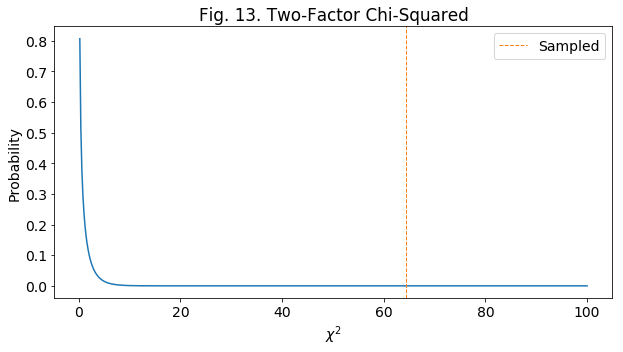

In [28]:
n = 4000000
h0_p = 0.0048
h1_p = 0.0052
avg_p = (h0_p + h1_p) / 2

chi_squared = n*(h1_p-avg_p)**2/avg_p + n*(h0_p-avg_p)**2/avg_p \
               + n*((1-h1_p) - (1-avg_p))**2/(1-avg_p) + n*((1-h0_p) - (1-avg_p))**2/(1-avg_p)

cmap = plt.get_cmap("tab10")
plt.figure(figsize=(10,5))

x = np.linspace(0, 100, 500)
y = stats.chi2.pdf(x, df=1)
plt.plot(x,y, color=cmap(0))
plt.xlabel(r'$\chi^2$')
plt.ylabel('Probability')
plt.axvline(x=chi_squared, ls='--', color=cmap(1), linewidth=1, label='Sampled')
plt.title('Fig. 13. Two-Factor Chi-Squared')
plt.legend()
plt.show()

First, we'll calculate the p-value by hand.

In [29]:
n = 4000000
h0_p = 0.0048
h1_p = 0.0052
avg_p = (h0_p + h1_p) / 2

chi_squared = n*(h1_p-avg_p)**2/avg_p + n*(h0_p-avg_p)**2/avg_p \
               + n*((1-h1_p) - (1-avg_p))**2/(1-avg_p) + n*((1-h0_p) - (1-avg_p))**2/(1-avg_p)
single_tailed_pvalue = stats.chi2.sf(chi_squared, df=1)
print('chi-squared:', ': {:.3}, p-value: {:.2}'.format(chi_squared, single_tailed_pvalue))

chi-squared: : 64.3, p-value: 1.1e-15


And now we use the build-ins. We have to include the delta degree of freedom term to take into account the multiple rows and columns.

In [30]:
n = 4000000
h0_p = 0.0048
h1_p = 0.0052
avg_p = (h0_p + h1_p) / 2
obs = [h1_p*n, h0_p*n, (1-h1_p)*n, (1-h0_p)*n]
ex = [avg_p*n, avg_p*n, (1-avg_p)*n, (1-avg_p)*n]

chisquared_results = stats.chisquare(obs, ex, ddof=2)
print('chi-squared:', ': {:.3}, p-value: {:.2}'.format(chisquared_results.statistic, chisquared_results.pvalue))

chi-squared: : 64.3, p-value: 1.1e-15
